---

## **Zillow Housing Price Predictor**

---

🏡 Capstone Project: Housing Price Prediction Using Zillow Data
Role: Machine Learning Engineer | Goal: Build a robust model to predict home prices based on historical Zillow housing data.
🧠 Objective:
Develop an end-to-end machine learning pipeline using Zillow housing data to accurately predict residential home prices. The project involved data preprocessing, feature engineering, model development, evaluation, and technical reporting.
📦 Dataset:
Source: Zillow housing dataset
Contents: Historical home sales data including features such as square footage, lot size, location, number of bedrooms/bathrooms, year built, and market variables.
Target Variable: Final sale price
Challenges Addressed: Missing data, skewed distributions, regional variability, feature selection
📊 Key Deliverables:
1. Final Report Notebook
Model Selection & Retrospective (Part A):
Selected the most performant model from earlier experiments using metrics such as RMSE and R² on validation sets.
Conducted a retrospective analysis of the data pipeline including data cleaning, feature transformations, model tuning, and evaluation strategy.
Refined previous stages to align with final model needs (e.g., encoding, scaling, outlier treatment).
Technical Report (Part B):
Authored a self-contained technical report for peer engineers and data scientists.
Included visualizations, modeling rationale, performance metrics, and code excerpts for reproducibility.
Followed industry-standard documentation structures (CMU DS report format, HOML checklist).
Clearly communicated model tradeoffs, performance analysis, and areas for future improvement.
🤝 Collaboration & Delivery:
Delivered as part of a collaborative team environment using Git and Jupyter Notebooks.
Final submission was consolidated and submitted by the team lead via Gradescope.
Emphasis placed on clean, extensible code and clear documentation for downstream integration or deployment.


Milestone 1: Feature Engineering Summary
In Milestone 1, I chose to fit a Linear Regression model using an exponentially transformed X and a logarithmically transformed y. I tested multiple transformation combinations and found that using both exponential or both logarithmic did not yield good results, but mixing the two showed promise. However, I did not carry these transformations forward into Milestone 2. Instead, I focused on engineering individual features rather than applying transformations to the entire dataframe. As a result, these earlier transformations were not implemented in the newly cleaned dataset.
Milestone 2: Model Fine-Tuning Summary
After performing Forward Feature Selection in Milestone 2, I identified the top-performing models as:
Random Forest Regressor
Gradient Boosting Regressor
Bagging Regressor
Initially, I tested n_estimators using the following range:
[50, 100, 150, ..., 500]
Both the Random Forest and Bagging Regressors selected 500 as the best value. The Gradient Boosting Regressor performed best at 200. To improve Random Forest and Bagging, I expanded the range up to 750, avoiding higher values to prevent crashes in VS Code. I kept the original range for Gradient Boosting, since further tuning was unnecessary.

Model Performance Comparison
Gradient Boosting Regressor
RMSE: 238,534.04
Std. RMSE: 1,474.90
Bagging Regressor
Old RMSE: 239,666.59 | Std. RMSE: 1,885.19
New RMSE: 239,385.54 | Std. RMSE: 1,858.33
Random Forest Regressor
Old RMSE: 241,304.65 | Std. RMSE: 1,914.55
New RMSE: 241,242.22 | Std. RMSE: 1,893.86
Conclusion
Although increasing the estimator range slightly improved performance for Bagging and Random Forest, both models still chose the upper limit (750) and required significantly longer run times. In contrast, the Gradient Boosting Regressor provided better performance and efficiency, even with a smaller range.
Based on these results, I concluded that the Gradient Boosting Regressor is the best model for this Zillow dataset. It strikes the right balance between predictive accuracy and computational efficiency, and I plan to continue using it with the original parameter range in future iterations.

---

In [ ]:
# =============================
# Useful Imports
# =============================

# Standard Libraries
import os
import time
import math
import io
import zipfile
import requests
from urllib.parse import urlparse
from itertools import chain, combinations

# Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as mticker  # Optional: Format y-axis labels as dollars

# Scikit-learn (Machine Learning)
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV,
    RepeatedKFold
)
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector, f_regression, SelectKBest, RFE
from sklearn.datasets import make_regression
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from scipy.stats import zscore

# Kaggle and Progress Tracking
import kagglehub
from tqdm import tqdm

# =============================
# Global Variables
# =============================
random_state = 42

# =============================
# Utility Functions
# =============================

# Format y-axis labels as dollars with commas (optional)
def dollar_format(x, pos):
    return f'${x:,.0f}'

# Convert seconds to HH:MM:SS format
def format_hms(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [ ]:
#Added for future use

from sklearn.metrics import make_scorer

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [ ]:
url = "https://www.cs.bu.edu/fac/snyder/cs505/Data/zillow_dataset.csv"

filename = os.path.basename(urlparse(url).path)

if not os.path.exists(filename):
    try:
        print("Downloading the file...")
        response = requests.get(url)
        response.raise_for_status()  # Raise an error for bad status codes
        with open(filename, "wb") as f:
            f.write(response.content)
        print("File downloaded successfully.")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading the file: {e}")
else:
    print("File already exists. Skipping download.")

df = pd.read_csv(filename)

File already exists. Skipping download.


Dropping Columns based on specific restraints.

In [ ]:
# Drop "ID" columns

df_id = df.filter(regex = "id").columns
df_id = [col for col in df_id if col != "regionidzip"] # keep regionidzip

df = df.drop(df_id, axis = 1)
len(df.columns) # should drop by 16 [55 -> 39]

# Drop propertycountylandusecode and propertyzoningdesc

df = df.drop(["propertycountylandusecode", "propertyzoningdesc"], axis = 1)
len(df.columns) # should drop by 2 [39 -> 37]

# Drop latitude and longitude

df = df.drop(["latitude", "longitude"], axis = 1)
len(df.columns) # should drop by 2 [37 -> 35]

# Drop finishedfloor1squarefeet and finishedsquarefeet50

df = df.drop(["finishedfloor1squarefeet", "finishedsquarefeet50"], axis = 1)
len(df.columns) # should drop by 2 [35 -> 33]

# Drop due to the number of unique values (has less than or equal to 3 or greater than or equal to 60% unique values)

drop_nunique_df = df.nunique()
drop_nunique_df = drop_nunique_df[(drop_nunique_df >= 0.6 * len(df)) | (drop_nunique_df < 3)]
drop_nunique_df = drop_nunique_df.index.tolist()
drop_nunique_df = [col for col in drop_nunique_df if col != "taxvaluedollarcnt"] # keep Target variable

df = df.drop(drop_nunique_df, axis = 1)
len(df.columns) # should drop by 5 [33 -> 28]

# Drop the "too many" missing/null variables (few missing values <5% values)

missing_df = (1 - df.count() / len(df)) * 100

drop_missing_df = missing_df[missing_df >= 95].index
drop_missing_df = [col for col in drop_missing_df if col in df]

df = df.drop(drop_missing_df, axis = 1)
len(df.columns) # should drop to 20 [28 -> 20]

20

Dropping rows based on specific retraints.

In [ ]:
# Removing rows with high null counts

row_threshold = df.shape[1] * 0.5

row_high_nulls = df[df.isnull().sum(axis=1) > row_threshold]

df = df.dropna(thresh=row_threshold)
print(f"Rows with over 50% nulls: {len(row_high_nulls)}")
print(f"New shape: {df.shape}")

#Removing outliers

df_numeric = df.select_dtypes(include=[np.number])
z_scores = np.abs(zscore(df_numeric, nan_policy='omit'))
outlier_rows = (z_scores > 3).any(axis=1)
outliers_df = df[outlier_rows]

outlier_mask = (z_scores > 3).any(axis=1)
df = df[~outlier_mask].copy()
print(f"Outlier rows detected: {outliers_df.shape[0]}")
print(f"Shape after removing outliers: {df.shape}")

Rows with over 50% nulls: 216
New shape: (77397, 20)
Outlier rows detected: 10069
Shape after removing outliers: (67328, 20)


Imputation for the remaining columns with missing values.

In [ ]:
# Imputation by filling with 0

impute_0 = ["fireplacecnt", "fullbathcnt", "threequarterbathnbr", "garagecarcnt", "unitcnt"]
df.loc[:, impute_0] = df[impute_0].fillna(0)

# Impute by the median

impute_median = ["calculatedbathnbr", "calculatedfinishedsquarefeet", "finishedsquarefeet12", "garagetotalsqft", "lotsizesquarefeet", "yearbuilt", "numberofstories"]
df.loc[:, impute_median] = df[impute_median].fillna(df[impute_median].median())

# Impute by the mode

impute_mode = ["censustractandblock", "taxvaluedollarcnt"]
mode = df[impute_mode].mode().iloc[0]
df[impute_mode] = df[impute_mode].fillna(mode)

# Remove based on missing data from regionidzip

df["regionidzip"].isnull().sum() # 29 missing values
df = df.dropna(subset = ["regionidzip"])

In [ ]:
missing = df.isna().sum()
missing[missing > 0]

Series([], dtype: int64)

There were no categorical variables to encode.

Create interaction and logarithmic features.

In [ ]:
# Interaction and logarithm features

df_new = df.copy()

df_new['garage_sqft_interaction'] = df['garagecarcnt'] * df['garagetotalsqft']
df_new['bath_times_bed'] = df['bathroomcnt'] * df['bedroomcnt']
df_new['log_lotsize'] = np.log1p(df['lotsizesquarefeet'])

In [ ]:
# Create features (X) and target (y) dataframes

X = df_new.drop(columns=["taxvaluedollarcnt"])
y = df_new["taxvaluedollarcnt"]

In [ ]:
# Splitting the Data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state)

In [ ]:
#Scaling the new features

scaler = StandardScaler()

X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)

Define and modify run_model and sweep_parameter function to include and return a CV RMSE and STD RMSE.

In [ ]:
def run_model(model, X_train, y_train, X_test, y_test, n_repeats=10, n_jobs=-1, **model_params):

    # Instantiate the model if a class is provided, so for example can use either BaggingRegressor or BaggingRegressor() as argument.
    if isinstance(model, type):
        model = model(**model_params)

    neg_mse_scores = cross_val_score(model, X_train_scaled, y_train,scoring = 'neg_mean_squared_error',
                                     cv = RepeatedKFold(n_splits=5, n_repeats=n_repeats, random_state=42), n_jobs  = n_jobs)

    mean_cv_mse = -np.mean(neg_mse_scores)
    std_cv_mse  = np.std(neg_mse_scores)

    # Calculate RMSE and standard deviation of RMSE
    rmse_scores = np.sqrt(-neg_mse_scores)
    mean_cv_rmse = np.mean(rmse_scores)
    std_rmse = np.std(rmse_scores)

    # Fit the model on the full training set
    model.fit(X_train_scaled, y_train)

    # Compute training MSE and testing MSE
    train_preds = model.predict(X_train_scaled)
    train_mse   = mean_squared_error(y_train, train_preds)
    test_preds  = model.predict(X_test)
    test_mse    = mean_squared_error(y_test, test_preds)

    return mean_cv_mse, std_cv_mse, train_mse, test_mse, mean_cv_rmse, std_rmse

In [ ]:
# Sweep Parameter

def sweep_parameter(model,
                    Parameters,
                    param,
                    parameter_list,
                    X_train          = X_train,
                    y_train          = y_train,
                    X_test           = X_test,
                    y_test           = y_test,
                    verbose          = True,
                    show_rmse        = True,
                    n_iter_no_change = None,
                    delta            = 0.001,
                    n_jobs           = -1,
                    n_repeats        = 10):

    start = time.time()
    Parameters = Parameters.copy()  # Avoid modifying the original dictionary

    cv_mses, std_cvs, train_mses, test_mses = [], [], [], []
    cv_rmses, std_rmses = [], []
    no_improve_count = 0
    best_mse = float('inf')

    # Run over each value in parameter_list
    for p in tqdm(parameter_list, desc=f"Sweeping {param}"):
        Parameters[param] = p
        P_temp = Parameters.copy()
        # Remove MSE_found if present, just in case
        P_temp.pop('MSE_found', None)
        P_temp.pop('std_rmse', None)

        cv_mse, std_cv, train_mse, test_mse, mean_cv_rmse, std_cv_rmse = run_model(
            model=model,
            X_train=X_train_scaled, y_train=y_train,
            X_test=X_test,   y_test=y_test,
            n_repeats=n_repeats,
            n_jobs=n_jobs,
            **P_temp
        )
        cv_mses.append(cv_mse)
        std_cvs.append(std_cv)
        train_mses.append(train_mse)
        test_mses.append(test_mse)
        cv_rmses.append(mean_cv_rmse)
        std_rmses.append(std_cv_rmse)

        # Early-stopping logic
        if cv_mse < best_mse - delta:
            best_mse = cv_mse
            no_improve_count = 0
        else:
            no_improve_count += 1

        if n_iter_no_change is not None and no_improve_count >= n_iter_no_change:
            print(f"Early stopping: No improvement after {n_iter_no_change} iterations.")
            break

    # Identify best parameter
    min_cv_mse = min(cv_mses)
    min_index = cv_mses.index(min_cv_mse)
    best_param = parameter_list[min_index]
    Parameters[param] = best_param
    Parameters['MSE_found'] = min_cv_mse
    Parameters['std_rmse'] = std_rmses[min_index]


    if verbose:
        # Prepare for plotting
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

        # We only need as many parameter values as we actually computed
        partial_param_list = parameter_list[:len(cv_mses)]

        # Check if our parameter list is Boolean so we can label accordingly
        is_boolean = all(isinstance(val, bool) for val in partial_param_list)
        if is_boolean:
            # Convert booleans to integer indices for plotting
            x_vals = list(range(len(partial_param_list)))
            x_labels = [str(val) for val in partial_param_list]
        else:
            # Treat numeric or other types as-is
            x_vals = partial_param_list
            x_labels = partial_param_list

        error_name = 'RMSE' if show_rmse else 'MSE'

        # ----- First plot: (R)MSE -----
        ax1.set_title(f"{error_name} vs {param}")

        # Apply dollar formatting ONLY if we're showing RMSE
        if show_rmse:
            ax1.yaxis.set_major_formatter(mticker.FuncFormatter(dollar_format))

        # Plot lines
        ax1.plot(x_vals,
                 np.sqrt(cv_mses) if show_rmse else cv_mses,
                 marker='.', label=f"CV {error_name}", color='blue')
        ax1.plot(x_vals,
                 np.sqrt(train_mses) if show_rmse else train_mses,
                 marker='.', label=f"Train {error_name}", color='green')
        ax1.plot(x_vals,
                 np.sqrt(test_mses) if show_rmse else test_mses,
                 linestyle='--', label=f"Test {error_name}", color='orange')
        ax1.scatter([x_vals[min_index]],
                    [np.sqrt(min_cv_mse) if show_rmse else min_cv_mse],
                    marker='x', label=f"Best CV {error_name}", color='red')

        ax1.set_ylabel(error_name)
        ax1.legend()
        ax1.grid()

        # ----- Second plot: CV Std Dev -----
        ax2.set_title(f"CV Standard Deviation vs {param}")
        ax2.plot(x_vals, std_cvs, marker='.', label=f"CV {error_name} Std", color='blue')
        ax2.set_xlabel(param)
        ax2.set_ylabel("Standard Deviation")
        ax2.legend()
        ax2.grid(alpha=0.5)

        # If we are using boolean x-values, set custom ticks
        if is_boolean:
            ax2.set_xticks(x_vals)
            ax2.set_xticklabels(x_labels)

        plt.tight_layout()
        plt.show()

        end = time.time()
        print("Execution Time:", time.strftime("%H:%M:%S", time.gmtime(end - start)))

    return Parameters

The best model we found is the Gradient Boosting Regressor.

In [ ]:
# Define Gradient Boosting Parameters

Default_Parameters_GradientBoosting = {
    'learning_rate'           : 0.1,             # Shrinks the contribution of each tree. Affects the speed of learning and overfitting.
    'n_estimators'            : 100,             # The number of boosting stages to be run. More estimators can improve performance but increase training time.
    'max_depth'               : 3,               # Maximum depth of individual trees. Controls model complexity.
    'max_features'            : None,            # Number of features to consider when looking for best split. Can help reduce overfitting.
    'random_state'            : 42,              # Controls randomness of boosting. Useful for reproducibility.
    'MSE_found'               : float('inf')     # NOT a parameter, but will record the MSE found for the current parameter choices
}

Sweeping learning_rate: 100%|██████████| 10/10 [04:00<00:00, 24.00s/it]


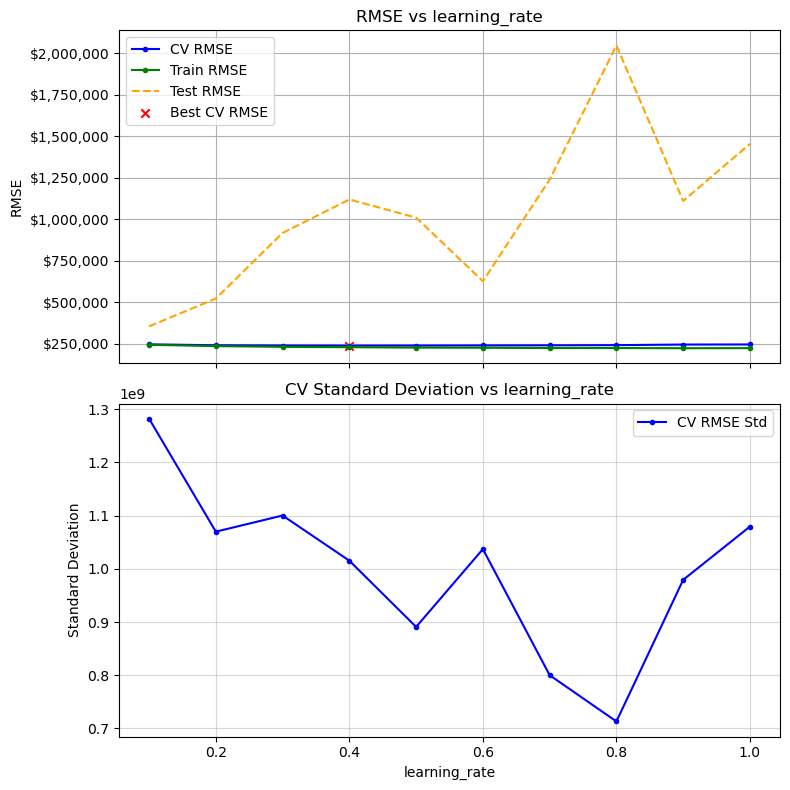

Execution Time: 00:04:00

 Parameter learning_rate = (0.4) RMSE = $239,926.88 Std. RMSE = $2,118.55

{'learning_rate': 0.4, 'n_estimators': 100, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 57564906893.110756, 'std_rmse': 2118.553691303341}



Sweeping n_estimators: 100%|██████████| 10/10 [09:38<00:00, 57.87s/it]


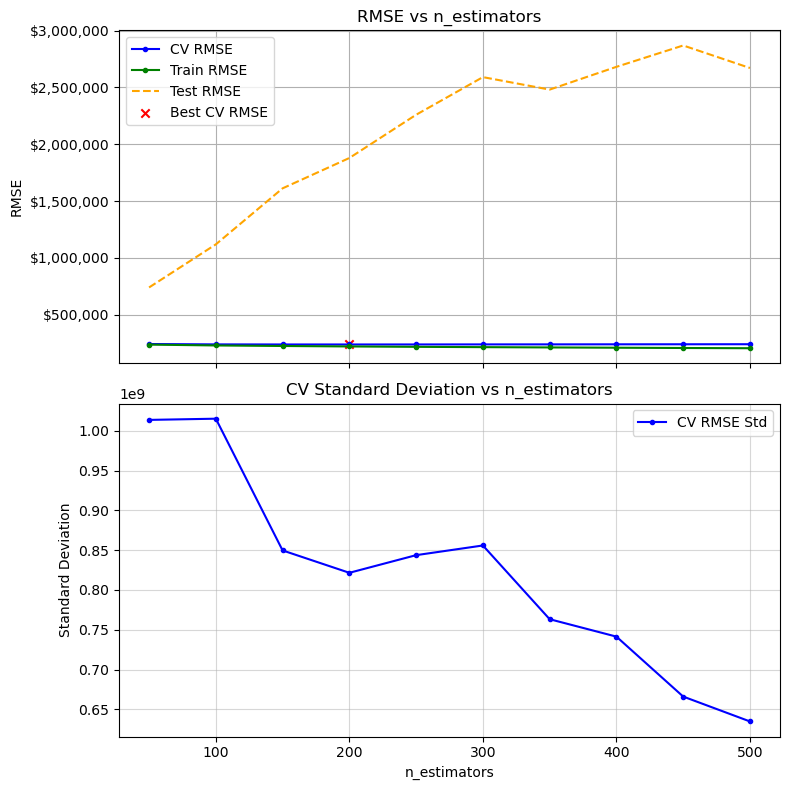

Execution Time: 00:09:39

 Parameter n_estimators = (200) RMSE = $239,182.68 Std. RMSE = $1,723.07

{'learning_rate': 0.4, 'n_estimators': 200, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 57208354368.66769, 'std_rmse': 1723.0650677481651}



Sweeping max_depth: 100%|██████████| 18/18 [45:57<00:00, 153.19s/it]


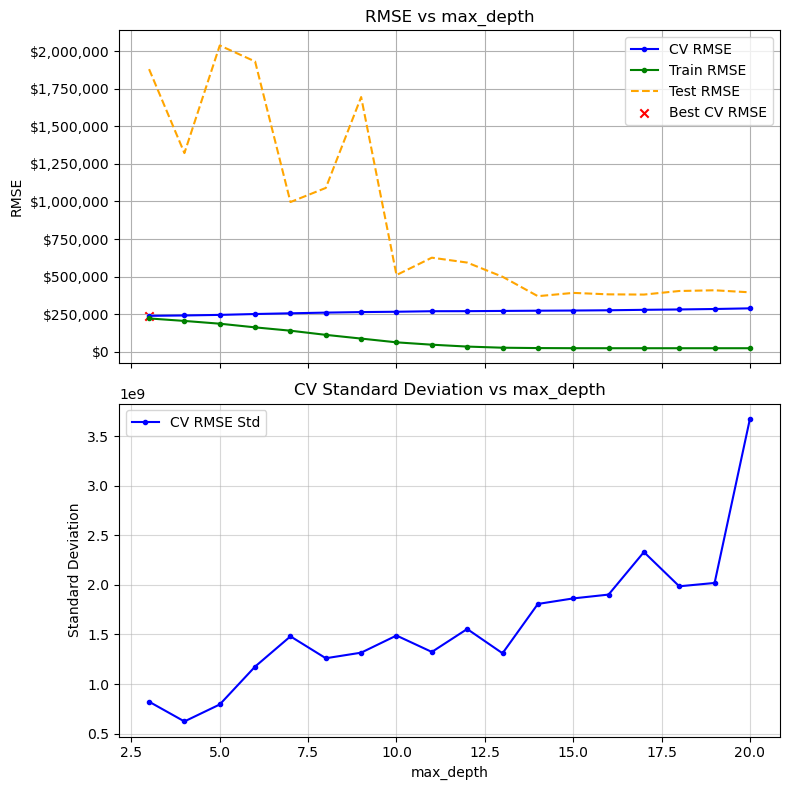

Execution Time: 00:45:57

 Parameter max_depth = (3) RMSE = $239,182.68 Std. RMSE = $1,723.07

{'learning_rate': 0.4, 'n_estimators': 200, 'max_depth': 3, 'max_features': None, 'random_state': 42, 'MSE_found': 57208354368.66769, 'std_rmse': 1723.0650677481651}



Sweeping max_features: 100%|██████████| 5/5 [01:53<00:00, 22.69s/it]


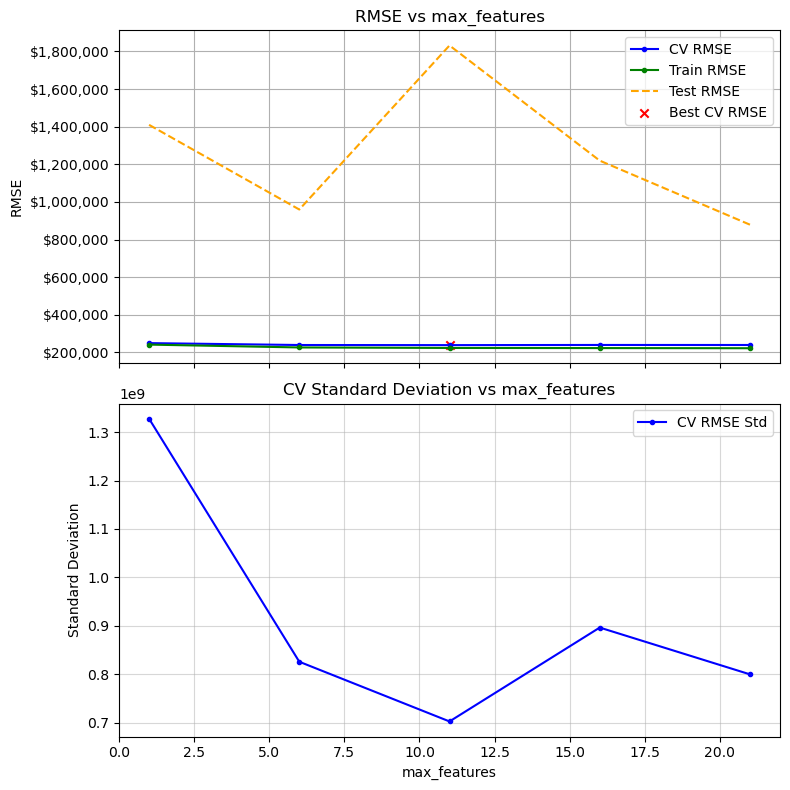

Execution Time: 00:01:53

 Parameter max_features = (11) RMSE = $238,534.04 Std. RMSE = $1,474.90

{'learning_rate': 0.4, 'n_estimators': 200, 'max_depth': 3, 'max_features': 11, 'random_state': 42, 'MSE_found': 56898488071.54875, 'std_rmse': 1474.8974694618073}



,learning_rate,n_estimators,max_depth,max_features,random_state,MSE_found,std_rmse
0,0.4,200,3,11,42,5.689849e+10,1474.897469


In [ ]:
# Run Gradient Boosting Model

Params_BT = Default_Parameters_GradientBoosting.copy()
Params_BT_List = []

parameters_and_ranges = [("learning_rate", np.linspace(0.1, 1.0, 10)),
                         ("n_estimators", range(50, 501, 50)),
                         ("max_depth", range(3, 21, 1)),
                         ("max_features", range(1, 23, 5)),
                         ]

for (param, parameter_list) in parameters_and_ranges:
    Params_BT = sweep_parameter(GradientBoostingRegressor,
                                Params_BT,
                                param,
                                parameter_list,
                                n_jobs = -1,
                                n_repeats = 2)

    print(f"\n Parameter {param} = ({Params_BT[param]}) RMSE = ${Params_BT["MSE_found"]**0.5:,.2f} Std. RMSE = ${Params_BT['std_rmse']:,.2f}\n")
    print(Params_BT)
    print()

Params_BT_List.append(Params_BT)
pd.DataFrame(Params_BT_List)

**And don't forget about commentary cells!**

## Part B: Final Data Science Project Report Assignment [30 pts]

This final report is the culmination of your semester-long Data Science project, building upon the exploratory analyses and modeling milestones you've already completed. Your report should clearly communicate your findings, analysis approach, and conclusions to a technical audience. The following structure and guidelines, informed by best practices, will help you prepare a professional and comprehensive document.

### Required Sections

Your report must include the following sections:


#### 1. Executive Summary (Abstract) [2 pts]
- Brief overview of the entire project (150–200 words)
- Clearly state the objective, approach, and key findings

Our objective for this dataset is to build a predictive model using Zillow property data to estimate home values (taxvaluedollarcnt). This supports pricing decisions for buyers/sellers, investment analysis for real estate firms, and value mapping for regional planners. We utilized data cleaning methods in order to determine which features were suitable



We followed specific methods to find out which one yielded the best results in terms of the CV RMSE and Standard Deviation RMSE, with respect to computational efficiency.

#### 2. Introduction [2 pts]
- Clearly introduce the topic and context of your project
- Describe the problem you are addressing (the problem statement)
- Clearly state the objectives and goals of your analysis

Note: You may imaginatively consider this project as taking place in a real estate company with a small data science group in-house, and write your introduction from this point of view (don't worry about verisimilitude to an actual company!).  



---


In the real estate market, accurately predicting housing prices is critical for investment decisions, property valuation, and customer satisfaction.

 As a team we sought to improve price prediction accuracy while ensuring the model is understandable. Our goal was to systematically clean, transform, and model the data to create powerful, interpretable predictive tools that could drive better decision-making across the organization.

#### 3. Data Description [2 pts]
- Describe the source of your dataset (described in Milestone 1)
- Clearly state the characteristics of your data (size, types of features, missing values, target, etc.)



---
Our project utilized the Zillow housing dataset, consisting of several thousand residential property records. The dataset included a mix of numerical and categorical features, such as square footage, number of bedrooms/bathrooms, lot size, and tax information.

Our target variable was the property price. The key challenges included handling missing data, addressing outliers, and transforming skewed distributions to better align with model assumptions.



---





#### 4. Methodology (What you did, and why)  [12 pts]

**Focus this section entirely on the steps you took and your reasoning behind them. Emphasize the process and decision-making, not the results themselves**

- Describe your analytical framework
  - Use of validation curves to see the effect of various hyperparameter choices, and
  - Choice of RMSE as primary error metric
- Clearly outline your data cleaning and preprocessing steps
  - Describe what issues you encountered in the raw data and how you addressed them.
  - Mention any key decisions (e.g., removing samples with too many missing values).
  - What worked and what didn't work?
- Describe your feature engineering approach
  - Explain any transformations, combinations, or derived features.
  - Discuss why certain features were chosen or created, even if they were later discarded.
  - What worked and what didn't work?
- Detail your model selection process
  - Outline the models you experimented with and why.
  - Discuss how you evaluated generalization (e.g., cross-validation, shape and relationships of plots).
  - Mention how you tuned hyperparameters or selected the final model.





---


**Analytical Framework**

We compared different models using RMSE, which we picked because it shows when our predictions are way off. Having a feel for accuracy us important in real estate where prices can change a lot.

**Data Cleaning and Preprocessing**


1.   Handling Missing Values: We removed features with over 95% missing data and dropped or imputed others using median imputation.

2.   Outlier Removal: Records with unrealistic feature values.

3. Transformations: Features with right-skewed distributions, such as living area, were log-transformed to improve model fit.

4. Decisions: We prioritized simplifying the feature set for more clarity in what drives the predictions.






**Feature Engineering**

* Derived Features: We created interaction
terms, such as the product of garage size and living area, to capture complex relationships.

* Feature Selection: Forward feature selection techniques were used to retain the most impactful predictors.

* Challenges: Some of engineered features where not useful during validation and were ultimately discarded.

**Model Selection and Evaluation**

* Model Testing: We experimented with Linear Regression, Ridge, Lasso, Decision Trees, Bagging, Random Forest, and Gradient Boosting Trees.

* Evaluation Strategy: We examined mean and standard deviation of RMSE to balance predictive power and stability.

* Tuning: Hyperparameters like the number of estimators and maximum tree depth were adjusted based on validation results.

* Generalization Checks: We reviewed model learning curves and validation results to ensure no overfitting occurred. Ultimately, Random Forest and Gradient Boosting delivered the best balance of accuracy and stability.




---



#### 5. Results and Evaluation (What you found, and how well it worked) [10 pts]

**Focus purely on outcomes, with metrics, visuals, and insights. This is where you present evidence to support your conclusions.**

- Provide a clear and detailed narrative of your analysis and reasoning using the analytical approach described in (4).
- Discuss model performance metrics and results (RMSE, R2, etc.)
- **Include relevant visualizations (graphs, charts, tables) with appropriate labels and captions**
- Error analysis
  - Highlight specific patterns of error, outliers, or questionable features.
  - Note anything surprising or worth improving in future iterations.


# **Results and Evaluation**


**Reasoning**

We aimed to predict home values using Zillow data. We compared regression models using RMSE, chosen for its sensitivity to large prediction errors important for critical predictions.

Data cleaning and preprocessing involved removing high-missing-value features, imputing others with the median, and removing outliers. We prioritized a simpler feature set.

In feature engineering, we created interaction terms (e.g., garage size * living area) and used forward selection for impactful predictors. Some engineered features were discarded we determined they were low value.

For model selection and evaluation, we tested Linear Regression, Ridge, Lasso, Decision Trees, Bagging, Random Forest, and Gradient Boosting Trees. We evaluated mean and standard deviation of RMSE, tuning hyperparameters based on validation.


**Performance**

We measured top performance by models with Root Mean Squared Error (RMSE) and Standard Deviation of RMSE.



**Visuals**

**Error Analysis**


---



#### 6. Conclusion [2 pts]
- Clearly state your main findings and how they address your original objectives
- Highlight the business or practical implications of your findings
- Discuss the limitations and constraints of your analysis clearly and transparently
- Suggest potential improvements or future directions



---
**Main Findings vs. Objectives**

* Our objective for this dataset, is to develop a predictive model for estimating home values. The model will support pricing decisions for buyers and sellers, enable investment analysis for real estate firms, and facilitate value mapping for regional planners. Through data cleaning, we identified the best features for a price prediction model.

* Our main findings indicate that Random Forest and Gradient Boosting Trees were the best-performing models. Notably, Random Forest achieved the lowest mean Root Mean Squared Error (RMSE) and the lowest standard deviation of RMSE. While Bagging also performed well, Linear, Ridge, and Lasso Regression models yielded less satisfactory results.




**Business and Practical Implications**

* Developing accurate home price prediction models fosters greater transparency, efficiency, and stability in the real estate market, benefiting individuals, businesses, and the overall economy by enabling more informed and strategic decision-making.

**Limitations and Constraints**
* Processing and cleaning the data resulted in a 25% reduction in overall data.
  * Features with over 95% missing values
  * Fields with low predictive value or redundancy
  * Duplicated features


**Potential Improvements and Next Steps**
  * Further Improvements:
    * Hypertuning using Grid/Random Search
    * Cross Validation with Expanded Folds
  * Expermentation andTesting w/Other models




---





